In [1]:
%load_ext autoreload

In [2]:

%autoreload
import os
import time
from PIL import Image
from math import sin, cos, pi, tan
import numpy as np
import cv2
import argparse
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.models import vgg
from BoundingBox3D.yolo.yolo import cv_Yolo
from BoundingBox3D.torch_lib.Dataset import *
from BoundingBox3D.torch_lib import Model, ClassAverages
from BoundingBox3D.library.Math import *
from BoundingBox3D.library.Plotting import *
import os
from data_utils import download_SV_img as download_sv

from MegaDepth import test as megadepth_test

from MegaDepth.options.train_options import TrainOptions

from viz import show_2D_bbox, show_flood, show_seg_mask
from segmentation import segmentation
from core_utils import filter_segmentation, get_thresh_coords_megadepth
from math import atan

In [3]:
addresses = np.array([
            [45.5306086,-73.6148085],
            [45.530608, -73.614964],
            [45.5305405,-73.6155206],
            [45.530095, -73.615002],
            [45.530178, -73.614715],
            [45.529515, -73.622325],
            [45.524653, -73.596550],
            [45.522775, -73.603377],
            [45.523305, -73.604910],
            [45.5227349,-73.6023362],
            [45.5231721,-73.6030411],
            [45.5231552,-73.6024024],
            [45.5235926,-73.5989186],
            [45.5236515,-73.5946721],
            [45.5234785,-73.591241],
            [45.5146551,-73.588218],
            [45.5094233,-73.5787649],
            [45.5051424,-73.578591]
            ])

In [4]:
key =  #YOUR GOOGLE STREETVIEW API KEY 

In [5]:
output_paths = download_sv.get_images([download_sv.param_block(address, key) for address in addresses],'./demo_data/') 

All images fetched


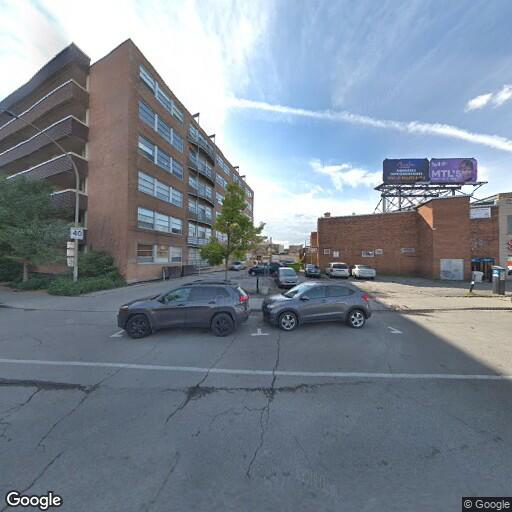

In [42]:
img_file = output_paths[5]
Image.open(img_file)

In [43]:
%tb
megadepth_test.get_depthmap_img(img_file, './demo_data/', [512,512], '/network/home/tengmeli/height_estimation/src/MegaDepth/checkpoints/')


No traceback available to show.


===========================================LOADING Hourglass NETWORK====================================================
/network/home/tengmeli/height_estimation/src/MegaDepth/checkpoints/test_local/best_generalization_net_G.pth
model [HGModel] was created
[512, 512]
============================= TEST ============================


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Image saved to ./demo_data/gsv_000005_depth.jpg
We are done


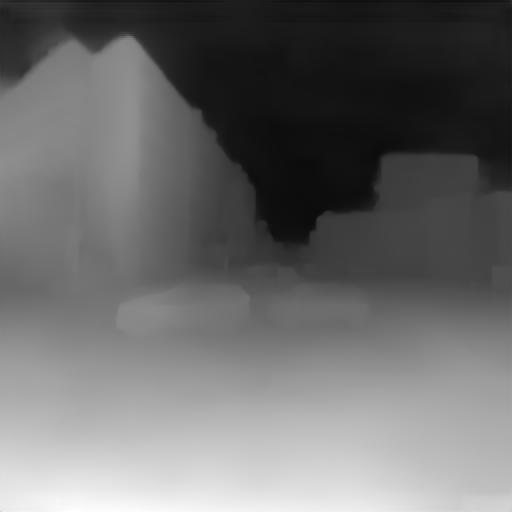

In [44]:
depth_path = './demo_data/gsv_000005_depth.jpg'
Image.open(depth_path)

In [45]:
weights_path = "./BoundingBox3D/weights/"
yolo_path ="./BoundingBox3D/weights"

model_lst = [x for x in sorted(os.listdir(weights_path)) if x.endswith('.pkl')]
if len(model_lst) == 0:
    print('No previous model found, please train first!')
    exit()
else:
    print('Using previous model %s'%model_lst[-1])
    my_vgg = vgg.vgg19_bn(pretrained=True)
    # TODO: load bins from file or something
    model = Model.Model(features=my_vgg.features, bins=2).cuda()
    checkpoint = torch.load(weights_path + '/%s'%model_lst[-1])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

yolo = cv_Yolo(yolo_path)
averages = ClassAverages.ClassAverages()
angle_bins = generate_bins(2)

Using previous model epoch_10.pkl


(512, 512, 3)


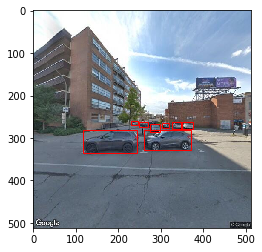

In [46]:
truth_img = cv2.imread(img_file)
img = np.copy(truth_img)
yolo_img = np.copy(truth_img)
detections = yolo.detect(yolo_img)

show_2D_bbox(img_file, detections)

Segmentation done


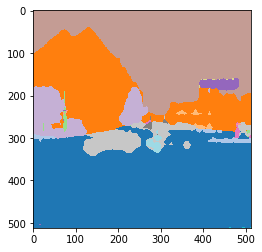

In [47]:
masks = segmentation.segment_19classes([img_file], "/network/tmp1/ccai/checkpoints/roadSegmentation/resnet_34_8s_cityscapes_best.pth" , './demo_data/')

show_seg_mask(masks[0])

In [51]:
classes = {'car':13, 'truck':14, 'motorcycle':17}
depth = np.array(Image.open(depth_path))
#The initial FOV in the API was 120°. But we center-cropped the image, taking out margins of 20 pixels on all sides (to get rid of the watermarks)
# We then resized the image to 512*512 so that we could apply MegaDepth on it ( some pixels are dilated)

H, W = 512, 512
init_FOVx = pi/3  #half FOV
init_FOVy = pi/3   #half FOV
FOVx = 2*atan(tan(init_FOVx)*((W/2)-20)/(W/2) )#initial FOV - angle corresponding to the crop
FOVy =  2*atan(((H/2)-20)/(H/2) * tan(init_FOVy))

mask = np.load(masks[0])

#Enter metric threshold
threshold = 0.5

coords, thresholds = get_thresh_coords_megadepth(img, threshold, depth, FOVx, FOVy, detections, mask, classes, model,pix_threshold = 0.3)

[1, 2, 3, 4, 5, 6, 7]
-7.466974457665433 -13.036085770100161
[1.5683928 1.6699531 4.232683 ]
height of the detected object of class car in meters is : 1.6699531
-8.209306425272333 -10.468656374610138
[1.5529984 1.6620408 3.921194 ]
height of the detected object of class car in meters is : 1.6620408
-7.768775024328503 -10.737222333485832
[1.5383023 1.6267625 3.8397236]
height of the detected object of class car in meters is : 1.6267625
-7.861940953219462 -9.845557412457115
[1.5207272 1.6337454 4.073333 ]
height of the detected object of class car in meters is : 1.6337454
-7.381194945037796 -8.521643439787107
[1.4809735 1.6035776 3.8592174]
height of the detected object of class car in meters is : 1.6035776
-7.9890407248004145 -10.57696528373231
[1.5227066 1.6730673 4.0904727]
height of the detected object of class car in meters is : 1.6730673
-8.141023836438753 -8.431646819394786
[1.4953729 1.5778083 3.5167017]
height of the detected object of class car in meters is : 1.5778083


In [52]:
thresholds, np.mean(thresholds)

([-11.368640353127178,
  -9.788964904635233,
  -9.824843516017662,
  -9.238481052668694,
  -8.166048398763477,
  -9.803558108033275,
  -8.339549766110565],
 -9.504298014193726)

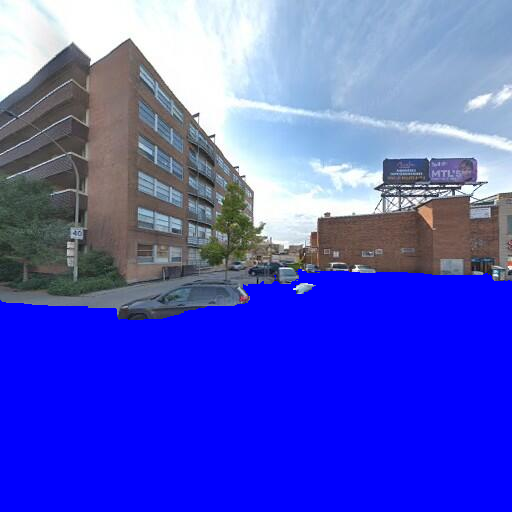

<Figure size 432x288 with 0 Axes>

In [53]:
show_flood(img, np.mean(thresholds), coords)